# Imports and Constants

In [61]:
lazy_copy = 'labeled_samples_2024-08-09 16/14/00'

import numpy as np
from datetime import datetime
import numpy as np
from math import floor
from utils import *
from functools import partial
import torch
from torch import nn
from math import floor, ceil
import pandas as pd
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt


right_now = datetime.now().replace(microsecond=0, second=0)
label_col = 'answer_vector'
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
seed = 42 # np.randint(0, 110)

mapping = lambda s: {'background': 'context',
                     'future_work': 'context',
                    'differences': 'context',
                     'future work': 'context',
                     'motivation': 'context',
                     'similarities': 'context',
                     'extends': 'uses',
                     'uses': 'uses',
                     '*': 'context'
                     }.get(s) or s


vector_from_string = lambda s: np.array(list(
                                map(float,
                                filter(None, 
                                map( str.strip, 
                                    s[1:-1].split(' ')
                    )))))

vector_from_string_bool = lambda s: np.array(list(
                                map(lambda s: {'true': 1, 'false': 0, '1': 1, '0': 0}.get(s.lower()),
                                filter(None, 
                                map( str.strip, 
                                    s[1:-1].split(' ')
                    )))))

# Load existing or default dataframe, query LLM

In [62]:
other_path = f'~/Desktop/2. FutureTech/uniform_sample/results/{lazy_copy.replace('/',':')}.csv'
df = pd.read_csv(other_path) #update_labels(other_path, save = True)


df = df.sort_values(by = 'multisentence').reset_index(drop = True)
df = df.sample(frac=1, random_state = seed)
#df.rename(columns={'json_booleans':'json_response'}, inplace = True)
print(len(df))
df.head()

df['answer_vector'] = df['answer_vector'].apply(lambda s: vector_from_string_bool(s))


519


In [63]:
total_questions = df['answer_vector'].apply(len).max()
assert(total_questions == df['answer_vector'].apply(len).min())


In [64]:
split = floor(2/3 * len(df))
print(f"Test-train split: {split}, {len(df) - split}")

df_train, df_test = df.iloc[:split], df.iloc[split:]

 
label_mask = lambda s: df_train['alex'].apply(mapping) == s
labels = sorted(list({mapping(item) for item in ['background', 'extends', 'uses']}))
per_label_samples = max([len(df_train[label_mask(label)]) for label in labels])
per_label_multipliers = [ceil(per_label_samples/len(df_train[label_mask(label)])) for label in labels]


#comment out this line to use the original distribution
df_train = pd.concat([df_train[label_mask(label)] for label, multiplier in zip(labels, per_label_multipliers) for _ in range(0, multiplier)])
print(f"Training size {len(df_train)}")

Test-train split: 346, 173
Training size 538


# Creating a model!

In [65]:
X_train, y_train = (np.stack(df_train['answer_vector']), 
                        np.array(df_train['alex'].apply(mapping).apply(lambda s: {'context': 0, 'uses': 1, 'extends': 2}.get(s)))
                )

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32).reshape(-1, 1)


X_test = torch.tensor(np.stack(df_test['answer_vector']), dtype = torch.float32)
y_test = torch.tensor(np.array(df_test['alex'].apply(mapping).apply(lambda s: {'context': 0, 'uses': 1, 'extends': 2}.get(s))), dtype = torch.float32).reshape(-1, 1)
print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)

c = Counter([el.item() for el in y_test])
print(f"Background composition: {c[0]/len(df_test)}")


Training shape: torch.Size([538, 60]) torch.Size([538, 1])
Testing shape: torch.Size([173, 60]) torch.Size([173, 1])
Background composition: 0.6936416184971098


[46, 39, 37, 59, 49, 55, 36, 33, 47, 56]


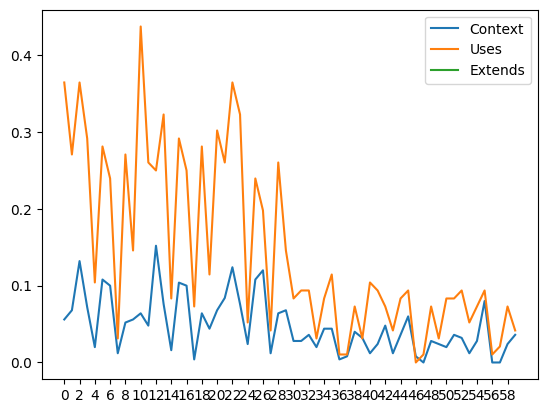

In [66]:
plt.plot(question_frequency_distribution(X_train, y_train, 0))
plt.plot(question_frequency_distribution(X_train, y_train, 1))
plt.plot(question_frequency_distribution(X_train, y_train, 2))
plt.xticks(ticks = [i for i in range(X_train.shape[1]) if i % 2 == 0])

plt.legend(["Context", "Uses", "Extends"])

print(get_highest_relative_questions(X_train, y_train, target_index = 0, reference_index = 1, n = 10))

In [67]:
model = generateModel(
            input_size = total_questions,
            classes = len(labels),
            dropout_rate=0.75,
            depth = 5,
            base = 1
)

loss_fn = nn.CrossEntropyLoss()

model = model.to(device) # device = 'mps'
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [68]:
def train_model(model, verbose = False, iters = 1000, lr = 1e-4):
    lr = lr * 10 # hacky and stupid
    learning_rate_horizons = {0, 10000, 5000000}
    train_accuracies, test_accuracies = [], []
    
    
    
    for epoch in range(iters):
        if (epoch in learning_rate_horizons):
            lr = lr / 10
            print(f"lr: {lr}")
            optimizer = torch.optim.Adam(params = model.parameters(), lr = lr)

        output = model(X_train)
        loss = loss_fn(output, y_train.reshape(-1,))
        
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_accuracy = (output.argmax(dim = 1) == y_train.reshape(-1, )).sum().item()/len(y_train)
        test_accuracy = (model(X_test).argmax(dim = 1) == y_test.reshape(-1,)).sum().item()/len(y_test)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if (epoch % 100 == 0 and verbose):
            print(f"Epoch: {epoch}, train loss: {loss.item()}, train acc: {train_accuracy}, test ac {test_accuracy}")
            
    
    return train_accuracies, test_accuracies


train_accuracies, test_accuracies = train_model(model, verbose=True, iters = 1000)

lr: 0.0001
Epoch: 0, train loss: 0.6928544640541077, train acc: 0.49256505576208176, test ac 0.28901734104046245
Epoch: 100, train loss: 0.677486002445221, train acc: 0.5353159851301115, test ac 0.3063583815028902
Epoch: 200, train loss: 0.6442703008651733, train acc: 0.5408921933085502, test ac 0.3179190751445087
Epoch: 300, train loss: 0.6279240250587463, train acc: 0.6747211895910781, test ac 0.6011560693641619
Epoch: 400, train loss: 0.6227395534515381, train acc: 0.6988847583643123, test ac 0.6589595375722543
Epoch: 500, train loss: 0.6038207411766052, train acc: 0.7267657992565055, test ac 0.7052023121387283
Epoch: 600, train loss: 0.5759884119033813, train acc: 0.7602230483271375, test ac 0.7167630057803468
Epoch: 700, train loss: 0.5521025657653809, train acc: 0.7695167286245354, test ac 0.7109826589595376
Epoch: 800, train loss: 0.5283446907997131, train acc: 0.7862453531598513, test ac 0.7052023121387283
Epoch: 900, train loss: 0.5159335732460022, train acc: 0.797397769516728

In [69]:
def run_model(v, threshold = .99):
    if v is None:
        return None
    
    ten = torch.Tensor(v).to(device).reshape(1, -1)
    rankings = model(ten).to('cpu').detach().numpy().reshape(-1, )
    classification = rankings.argmax()
    
    if (rankings[classification] >= threshold):
        return {0: 'context', 1:'uses', 2:'extends'}.get(classification) 
    
    return 'context'

df['learned_classification'] = df['answer_vector'].apply(run_model)
fp, fn = get_fp_fn(y_true=y_test, y_pred=df['learned_classification'].iloc[split:], verbose=False)

df.to_csv(other_path, index = False)
print(f"False positive {fp}, False negative {fn}")

False positive 0.43333333333333335, False negative 0.6792452830188679


In [70]:
print(f"Last test acc: {test_accuracies[-1]}")
print(Counter(df['learned_classification']))
print(f"Test labels hash: {hash_dataframe(list(df_test['alex']))}")
print(f"Test labels hash: {hash_dataframe(list(df['learned_classification'].iloc[split:]))}")


Last test acc: 0.6994219653179191
Counter({'context': 423, 'uses': 96})
Test labels hash: b'=\xabg\x14\x9c\x88\xa5\xea\x8b2#)\x94Aq0'
Test labels hash: b'\xc4<\xf7\xd1\x8f\x12eJ\x10@D\xb9\xac\xc1\xeb\xec'


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


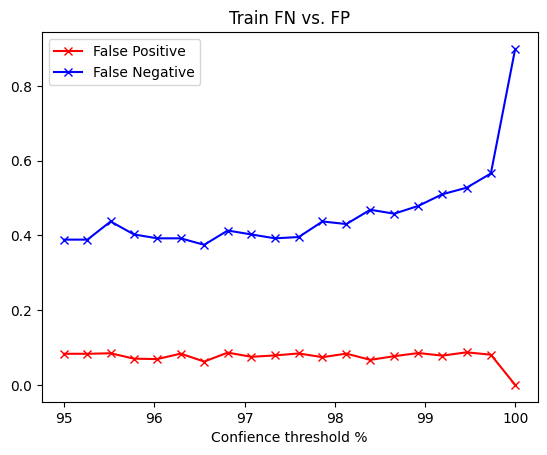

In [71]:
def pareto_plot(X, y, start = .95, end = 1, num = 20, verbose = False, test_or_train = "Test"):
    fps, fns = [], []
    thresholds = np.geomspace(start, end, num = num)
    
    for t in tqdm(thresholds):
        pred = np.array([run_model(X[v,:], threshold = t) for v in range(len(X))])
        
        fp, fn = get_fp_fn(y, pred, positive_label = 'uses', positive_index=1, verbose = verbose)
    
        fps.append(fp)
        fns.append(fn)
    
    plt.title(f"{test_or_train} FN vs. FP")
    plt.plot(thresholds * 100,fps, 'xr-')
    plt.plot(thresholds * 100,fns, 'xb-')
    plt.legend(['False Positive', 'False Negative'])
    plt.xlabel("Confience threshold %")
    
pareto_plot(X_train, y_train, verbose = False, test_or_train = "Train")


100%|██████████| 20/20 [00:02<00:00,  9.92it/s]


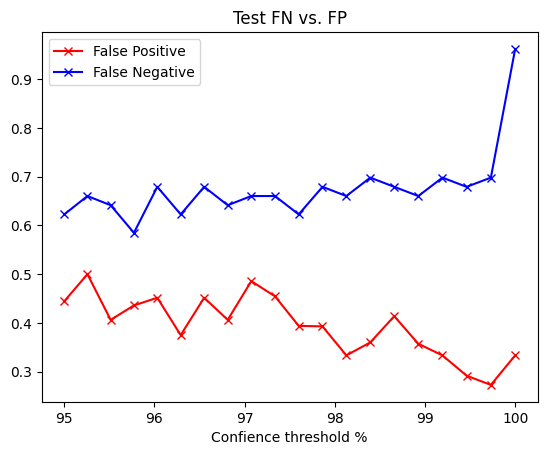

In [72]:
pareto_plot(X_test, y_test, test_or_train = "Test")